In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, '../src')

In [3]:
import math
from collections import OrderedDict as odict

import torch
import torch.nn as nn
from model import Generator, Discriminator
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from data_utils import ImageFilelistMultiscale, show_batch
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [5]:
dataset = ImageFilelistMultiscale('/home/samenabar/datasets/CLEVR_v1.0/images/train/', '*.png', resolutions=((64,64),))
# subset = torch.utils.data.Subset(dataset, list(range(1024)))

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=False,
)
batch64, = next(iter(loader))

In [6]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=False,
)
# batch64, = next(iter(loader))
# subdataset = torch.utils.data.TensorDataset(batch64.to(device))
# sub_loader = torch.utils.data.DataLoader(
#     subdataset,
#     batch_size=2,
#     shuffle=False,
#     pin_memory=False,
# )
# sub_batch64, = next(iter(sub_loader))

In [7]:
# sub_batch64.size()

In [8]:
# def generator_loss(generated, style_fake=None):
#     total_g_loss = torch.nn.functional.binary_cross_entropy_with_logits(generated, torch.ones_like(generated), reduction='none')
#     if style_fake:
#         total_g_loss = total_g_loss + style_loss(style_fake, "ones")

#     return total_g_loss

def calc_different_loss(prediction):
    return torch.nn.functional.binary_cross_entropy_with_logits(prediction, torch.zeros_like(prediction), reduction='none')

def calc_same_loss(prediction):
    return torch.nn.functional.binary_cross_entropy_with_logits(prediction, torch.ones_like(prediction), reduction='none')

In [9]:
class GenWrapper(nn.Module):
    def __init__(self, num_objs=10, z_bg_dim=32, z_fg_dim=64, iters=10, lr=1e-4):
        super().__init__()
        self.bg_emb = nn.Parameter(torch.empty(1, z_bg_dim).normal_(0, 0.02))
        self.fg_emb = nn.Parameter(torch.empty(1, num_objs, z_fg_dim).normal_(0, 0.02))
        self.az_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.02))
        self.tx_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.02))
        self.tz_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.02))
        self.scale_emb = nn.Parameter(torch.empty(1, num_objs, 32).normal_(0, 0.02))
        
        self.az_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.tx_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.tz_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.scale_proj = nn.Sequential(nn.Linear(32, 32), nn.LeakyReLU(0.2), nn.Linear(32, 2))
        self.pres_proj = nn.Sequential(nn.Linear(z_fg_dim, 32), nn.LeakyReLU(0.2), nn.Linear(32, 1))
        _11 = torch.tensor((-1.0, 1.0))
        self.register_buffer('_11', _11)
        _051 = torch.tensor((0.5, 1.0))
        self.register_buffer('_051', _051)
        _pipi = torch.tensor((-math.pi / 4, math.pi / 4))
        self.register_buffer('_pipi', _pipi)
        
        self.apply(self.init_weights)
        
        self.pres_proj[2].weight.data.zero_()
        self.generator = Generator(z_dim_bg=z_bg_dim, z_dim_fg=z_fg_dim)
        
        self.lr = lr
        self.iters = iters
        self.mse_loss = nn.MSELoss(reduction='none')
        
    @staticmethod
    def requires_grad(m):
        for param in m.parameters():
            m.requires_grad = False
        
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Parameter):
            m.data.normal_(0, 0.02)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
            
    def zero_grad_embs(self):
        self.bg_emb.grad.zero()
        self.fg_emb.grad.zero()
        self.az_emb.grad.zero()
        self.tx_emb.grad.zero()
        self.tz_emb.grad.zero()
        self.scale_emb.grad.zero()
            
    def forward(self, inp, disc, beta=1.0):
        bsz = inp.size(0)

        grad_norms = []
        recon_losses = []
        emb_recon_loss_triplets = []
        current_embs = odict([
            ('z_bg', self.bg_emb.expand(bsz, -1).detach().requires_grad_(True)),
            ('z_fg', self.fg_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_az', self.az_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_tx', self.tx_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_tz', self.tz_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
            ('z_scale', self.scale_emb.expand(bsz, -1, -1).detach().requires_grad_(True)),
        ])
        prev_disc_training = disc.training
        disc.train(False)

        with torch.enable_grad():
            for i in range(self.iters - 1):
                z_bg = current_embs['z_bg']
                pres = torch.sigmoid(beta * self.pres_proj(current_embs['z_fg']))
                z_fg = current_embs['z_fg'] * pres
                az = (self.az_proj(current_embs['z_az']).softmax(-1) * self._pipi).sum(-1, keepdim=True) * pres
                scale = (self.scale_proj(current_embs['z_scale']).softmax(-1) * self._051).sum(-1, keepdim=True) * pres
                tx = (self.tx_proj(current_embs['z_tx']).softmax(-1) * self._11).sum(-1, keepdim=True) * pres
                tz = (self.tz_proj(current_embs['z_tz']).softmax(-1) * self._11).sum(-1, keepdim=True) * pres
                scale = scale.clamp(1e-3)
                elev = tilt = ty = torch.zeros_like(az)
                view_in_fg = torch.cat([az, elev, tilt, scale, scale, scale, tx, ty, tz], -1)

                recon = self.generator(z_bg, z_fg, view_in_fg=view_in_fg)
                with torch.no_grad():
                    recon_loss = self.mse_loss(recon.detach(), inp).flatten(1).sum().mean() # to see progress only
                recon_losses.append(recon_loss)
                # we want the discriminator to say these are the same images and real images
                adv_loss = calc_generator_loss(inp, recon, disc)

                all_grads = torch.autograd.grad(
                    inputs=current_embs.values(),
                    outputs=adv_loss,
                    only_inputs=True,
                    create_graph=True,
                )

                if self.training:
                    emb_recon_loss_triplets.append(
                        (odict([(k, emb) for k, emb in current_embs.items()]), recon, adv_loss)
                    )
                else:
                    emb_recon_loss_triplets.append(
                        (odict([(k, emb) for k, emb in current_embs.items()]), recon.detach_(), adv_loss.detach_())
                    )
                grad_norms.append(odict([(k, g.norm()) for g, k in zip(all_grads, current_embs.keys())]))

                for grad, k in zip(all_grads, current_embs.keys()):
                    current_embs[k] = (current_embs[k] - self.lr * grad).detach().requires_grad_(True)

            z_bg = current_embs['z_bg']
            pres = torch.sigmoid(beta * self.pres_proj(current_embs['z_fg']))
            z_fg = current_embs['z_fg'] * pres
            az = (self.az_proj(current_embs['z_az']).softmax(-1) * self._pipi).sum(-1, keepdim=True) * pres
            scale = (self.scale_proj(current_embs['z_scale']).softmax(-1) * self._051).sum(-1, keepdim=True) * pres
            tx = (self.tx_proj(current_embs['z_tx']).softmax(-1) * self._11).sum(-1, keepdim=True) * pres
            tz = (self.tz_proj(current_embs['z_tz']).softmax(-1) * self._11).sum(-1, keepdim=True) * pres
            scale = scale.clamp(1e-3)
            elev = tilt = ty = torch.zeros_like(az)
            view_in_fg = torch.cat([az, elev, tilt, scale, scale, scale, tx, ty, tz], -1)

            recon = self.generator(z_bg, z_fg, view_in_fg=view_in_fg)
            with torch.no_grad():
                recon_loss = self.mse_loss(recon.detach(), inp).flatten(1).sum().mean()
            recon_losses.append(recon_loss)
            # we want the discriminator to say these are the same images and real images
            adv_loss = calc_generator_loss(inp, recon, disc) 
            all_grads = torch.autograd.grad(
                inputs=current_embs.values(),
                outputs=adv_loss,
                only_inputs=True,
                create_graph=True,
            )

            if self.training:
                emb_recon_loss_triplets.append(
                    (odict([(k, emb) for k, emb in current_embs.items()]), recon, adv_loss)
                )
            else:
                emb_recon_loss_triplets.append(
                    (odict([(k, emb) for k, emb in current_embs.items()]), recon.detach_(), adv_loss.detach_())
                )
            grad_norms.append(odict([(k, g.norm()) for g, k in zip(all_grads, current_embs.keys())]))
        disc.train(prev_disc_training)
        
        return emb_recon_loss_triplets, grad_norms, recon_losses

In [10]:
def calc_generator_loss(inp, recon, disc, return_adv_contrast_inp=False):
    bce_l = nn.BCEWithLogitsLoss(reduction='none')
    # shuffle real and fake images position to avoid overfitting
    bsz = inp.size(0)
    real_first = torch.rand(bsz, 1, 1, 1, device=inp.device) >= 0.5
    adv_contrast_inp = torch.cat((inp * real_first + recon * (~real_first), inp * ~real_first + recon * (real_first)), 1)
    contrast_pred = disc(adv_contrast_inp)
    real_first = real_first.view(bsz)
    # generator tries to make the discriminator say the real and fake images are the same
    are_same_loss = bce_l(contrast_pred[:, 0], torch.ones_like(real_first.float()))
    # try to make discrminator fake images are real
    are_real1 = contrast_pred[~real_first.squeeze(), 1]
    are_real1_loss = bce_l(are_real1, torch.ones_like(are_real1))
    are_real2 = contrast_pred[real_first.squeeze(), 2]
    are_real2_loss = bce_l(are_real2, torch.ones_like(are_real2))

    loss = (are_same_loss.sum() + are_real1_loss.sum() + are_real2_loss.sum()) / bsz
    if return_adv_contrast_inp:
        return loss, adv_contrast_inp
    return loss

In [11]:
def discriminator_update_step(inp, disc, gen):
    bsz = inp.size(0)
    ## DISCRIMINATOR STEP
    emb_recon_loss_triplets, grad_norms, _ = gen(inp, disc)

    # Different loss
    # Generate random permutation with all indices different
    indices = torch.arange(bsz)
    perm = torch.randperm(bsz)
    while (indices == perm).any():
        perm = torch.randperm(bsz)
    different_inp = torch.cat([inp, inp[perm]], 1)
    different_pred = disc(different_inp)
    different_loss = calc_different_loss(different_pred[:, 0]).mean()

    # Same loss
    same_inp = inp.repeat(1, 2, 1, 1)
    gate = torch.rand(bsz, 2, 1, 1, device=inp.device) < 0.3 # add noise to reduce overfitting to 30% of images
    gate = gate.repeat_interleave(3, 1)
    same_inp = (same_inp + torch.empty_like(same_inp).normal_(0, 0.02) * gate).clamp(0, 1)
    same_pred = disc(same_inp)
    same_loss = calc_same_loss(same_pred[:, 0])

    mult = 1
    total_contrastive_loss = 0.
    adv_contrast_inputs = []
    adv_contrast_preds = []
    contrastive_losses = []
    
    for (_, recon, _) in emb_recon_loss_triplets[::-1]:
        real_first = torch.rand(bsz, 1, 1, 1, device=device) >= 0.5
        adv_contrast_inp = torch.cat((inp * real_first + recon.detach() * (~real_first), inp * ~real_first + recon.detach() * (real_first)), 1)
        adv_contrast_inputs.append(adv_contrast_inp.detach())
        contrast_pred = disc(adv_contrast_inp)
        adv_contrast_preds.append(contrast_pred.detach())
        real_first = real_first.view(bsz, 1)
        # Target zero for first position: they are different
        # Target 1 for real images and 0 for fake images
        targ = torch.cat((torch.zeros_like(real_first), real_first, ~real_first), -1)
        contrastive_loss_i = bce_l(contrast_pred, targ.float())
        contrastive_losses.append(contrastive_loss_i.detach())
        total_contrastive_loss = total_contrastive_loss + mult * contrastive_loss_i.sum(-1).mean()
        mult = mult / 2

    total_disc_loss = different_loss.mean() + same_loss.mean() + total_contrastive_loss
    return total_disc_loss, {
        'different_inp': different_inp,
        'different_pred': different_pred.detach(),
        'different_loss': different_loss.detach(),
        'same_inp': same_inp,
        'same_pred': same_pred.detach(),
        'same_loss': same_loss.detach(),
        'adv_contrast_inputs': adv_contrast_inputs,
        'adv_contrast_preds': adv_contrast_preds,
        'contrastive_losses': contrastive_losses,
    }

def generator_update_step(inp, gen, disc):
    bsz = inp.size(0)
    emb_recon_loss_triplets, grad_norms, recon_losses = gen(inp, disc)
    mult = 1.0
    total_gen_loss = 0.
    for _, (_, _, gen_loss_i) in enumerate(emb_recon_loss_triplets[::-1]):
        total_gen_loss = total_gen_loss + mult * gen_loss_i
        mult /= 2
    # Backward for generator parameters (including initial projections)
    # total_gen_loss.backward(retain_graph=False)

    all_embs_list = []
    for triplet_i in emb_recon_loss_triplets:
        for k, emb in triplet_i[0].items():
            # emb.grad.zero_()
            all_embs_list.append((k, emb))
            
    # LETS TRY FIRST USING THE SAME WEIGHTED LOSS FOR THE EMBEDDINGS
    # mult = 1.0
    # total_emb_loss = 0.
    # for _, (_, _, gen_loss_i) in enumerate(emb_recon_loss_triplets):
    #     total_emb_loss = total_emb_loss + mult * gen_loss_i
    #     mult /= 2
    
    return total_gen_loss, all_embs_list, recon_losses

In [13]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
# batch64, = next(iter(loader))
# subdataset = torch.utils.data.TensorDataset(batch64.to(device))
# sub_loader = torch.utils.data.DataLoader(
#     subdataset,
#     batch_size=4,
#     shuffle=True,
#     pin_memory=False,
# )
# sub_batch64, = next(iter(sub_loader))

In [14]:
gen = GenWrapper(lr=1, iters=5).to(device)
disc = Discriminator().to(device)
# gen(torch.randn(2, 3, 64, 64).to(device), disc)
gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4)
disc_opt = torch.optim.Adam(disc.parameters(), lr=1e-4)
bce_l = nn.BCEWithLogitsLoss(reduction='none')

In [15]:
# torch.save({
#     'generator': gen.state_dict(),
#     'discriminator': disc.state_dict(),
#     'gen_opt': gen_opt.state_dict(),
#     'disc_opt': disc_opt.state_dict(),
# }, 'mawca.pth')

In [ ]:
n_epochs = 5
# pbar = tqdm(n_epochs)
disc.train(True)
gen.train(True)
for epoch in range(n_epochs):
    pbar = tqdm(loader)
    for i, (inp,) in enumerate(pbar):
        inp = inp.to(device)
        gen.train(False)
        total_disc_loss, disc_debug = discriminator_update_step(inp, disc, gen)
        total_disc_loss = (total_disc_loss - 0.2).abs() + 0.2
        total_disc_loss.backward()
        disc_opt.step()
        disc_opt.zero_grad()
        gen.train(True)

        ## GENERATOR STEP

        # emb_recon_loss_triplets, grad_norms = gen(inp, disc)
        # mult = 1.0
        # total_gen_loss = 0.
        # for _, (_, _, gen_loss_i) in enumerate(emb_recon_loss_triplets[::-1]):
        #     total_gen_loss = total_gen_loss + mult * gen_loss_i
        #     mult /= 2
        # Backward for generator parameters (including initial projections)
        # total_gen_loss.backward(retain_graph=False)

        # all_embs_list = []
        # for triplet_i in emb_recon_loss_triplets:
        #     for k, emb in triplet_i[0].items():
        #         # emb.grad.zero_()
        #         all_embs_list.append((k, emb))

        # LETS TRY FIRST USING THE SAME WEIGHTED LOSS FOR THE EMBEDDINGS
        # mult = 1.0
        # total_emb_loss = 0.
        # for _, (_, _, gen_loss_i) in enumerate(emb_recon_loss_triplets):
        #     total_emb_loss = total_emb_loss + mult * gen_loss_i
        #     mult /= 2

        # all_grads = torch.autograd.grad(
        #     inputs=[emb[1] for emb in all_embs_list],
        #     outputs=total_emb_loss,
        #     only_inputs=True,
        #     create_graph=True,
        # )

        total_gen_loss, all_embs_list, recon_losses = generator_update_step(inp, gen, disc)
        total_gen_loss = (total_gen_loss - 0.2).abs() + 0.2
        total_gen_loss.backward()
        
        all_grads_dict = {emb_name: [] for emb_name in ['z_bg', 'z_fg', 'z_az', 'z_tx', 'z_tz', 'z_scale']}
        # for (emb_name, emb), grad in zip(all_embs_list, all_grads):
        for (emb_name, emb) in all_embs_list:
            all_grads_dict[emb_name].append(emb.grad)
        all_grads_dict_sum = {emb_name: sum(grads).mean(0, keepdim=True) for emb_name, grads in all_grads_dict.items()}

        gen.bg_emb.grad = all_grads_dict_sum['z_bg']
        gen.fg_emb.grad = all_grads_dict_sum['z_fg']
        gen.az_emb.grad = all_grads_dict_sum['z_az']
        gen.tx_emb.grad = all_grads_dict_sum['z_tx']
        gen.tz_emb.grad = all_grads_dict_sum['z_tz']
        gen.scale_emb.grad = all_grads_dict_sum['z_scale']

        gen_opt.step()
        gen_opt.zero_grad()
        disc_opt.zero_grad()

        weights = torch.tensor([(1 / 2) ** (i) for i in range(len(recon_losses))][::-1], device=inp.device)
        exp_avg_recon_loss = (torch.stack(recon_losses) * weights).sum() / weights.sum()

        pbar.set_postfix(
            d_l=total_disc_loss.item(),
            g_l=total_gen_loss.item(),
            rec_l=exp_avg_recon_loss.item(),
        )
        
        if (i % 1000) == 0:
            torch.save({
                'generator': gen.state_dict(),
                'discriminator': disc.state_dict(),
                'gen_opt': gen_opt.state_dict(),
                'disc_opt': disc_opt.state_dict(),
            }, f'mawca_{epoch}_{i}.pth')

In [26]:
gen.train(False)
with torch.no_grad():
    emb_recon_loss_triplets, grad_norms, recon_losses = gen.cpu()(inp.cpu(), disc.cpu())

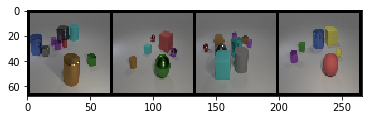

In [27]:
plt.imshow(to_pil_image(make_grid(inp).cpu()))

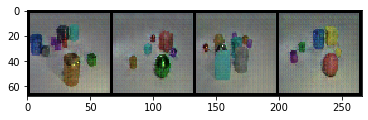

In [28]:
plt.imshow(to_pil_image(make_grid(emb_recon_loss_triplets[-1][1]).cpu()))

In [31]:
total_disc_loss, disc_debug = discriminator_update_step(inp, disc, gen)

In [32]:
total_disc_loss = total_disc_loss.detach()

In [33]:
disc_debug

{'different_inp': tensor([[[[0.4157, 0.4157, 0.4157,  ..., 0.4000, 0.4039, 0.4039],
           [0.4118, 0.4118, 0.4157,  ..., 0.4039, 0.4039, 0.4078],
           [0.4157, 0.4157, 0.4118,  ..., 0.4000, 0.4000, 0.3961],
           ...,
           [0.4706, 0.4667, 0.4667,  ..., 0.5490, 0.5490, 0.5412],
           [0.4706, 0.4667, 0.4706,  ..., 0.5529, 0.5529, 0.5451],
           [0.4667, 0.4706, 0.4706,  ..., 0.5608, 0.5569, 0.5490]],
 
          [[0.4157, 0.4157, 0.4118,  ..., 0.4000, 0.4039, 0.4039],
           [0.4118, 0.4078, 0.4157,  ..., 0.4039, 0.4039, 0.4078],
           [0.4157, 0.4118, 0.4118,  ..., 0.4000, 0.4000, 0.3961],
           ...,
           [0.4667, 0.4627, 0.4667,  ..., 0.5412, 0.5412, 0.5333],
           [0.4667, 0.4627, 0.4667,  ..., 0.5412, 0.5412, 0.5373],
           [0.4627, 0.4667, 0.4667,  ..., 0.5490, 0.5490, 0.5412]],
 
          [[0.4157, 0.4118, 0.4118,  ..., 0.4000, 0.4039, 0.4039],
           [0.4078, 0.4078, 0.4118,  ..., 0.4000, 0.4039, 0.4078],
       

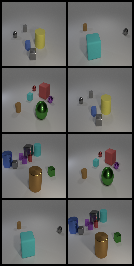

In [83]:
bsz = disc_debug['different_inp'].size(0)
to_pil_image(make_grid(disc_debug['different_inp'].cpu().view(-1, 3, 64, 64), nrow=2))

In [94]:
ax.set_title

<bound method Axes.set_title of <matplotlib.axes._subplots.AxesSubplot object at 0x7f79f047d3c8>>

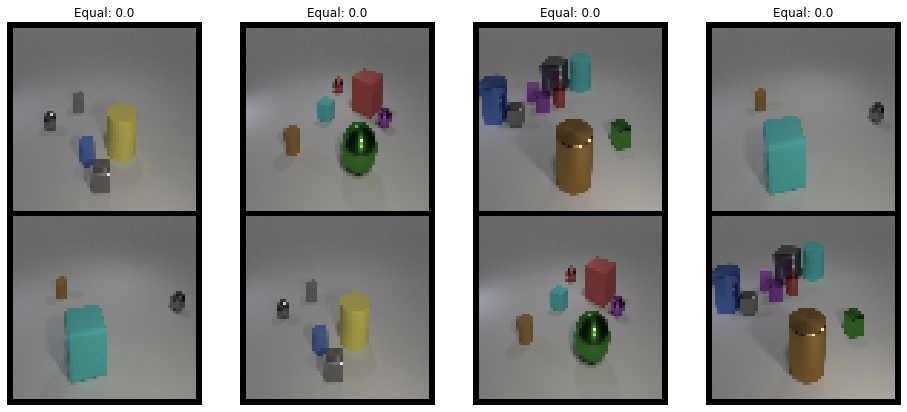

In [102]:
different_fig, different_axes = plt.subplots(nrows=1, ncols=bsz, figsize=(bsz * 4, 8))
for ax, pair, equal_prob in zip(different_axes, disc_debug['different_inp'].cpu(), torch.sigmoid(disc_debug['different_pred'].cpu()[:, 0])):
    img_pair_i = to_pil_image(make_grid(pair.view(2, 3, 64, 64), nrow=1))
    ax.imshow(img_pair_i)
    ax.set_title(f'Equal: {round(equal_prob.item(), 1)}')
    ax.axis('off')

In [143]:
same_inp = disc_debug['same_inp'].cpu()

gate = torch.rand(bsz, 2, 1, 1) > 0.5
gate = gate.repeat_interleave(3, 1)

same_inp = (same_inp + torch.empty_like(same_inp).normal_(0, 0.02) * gate).clamp(0, 1)

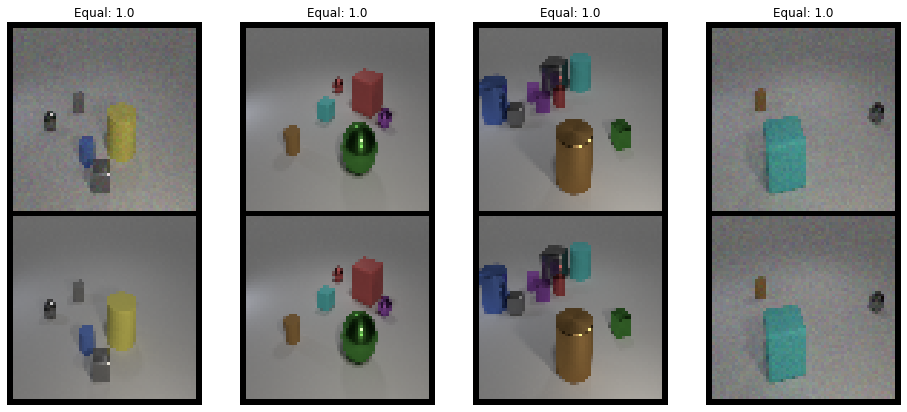

In [144]:
same_fig, same_axes = plt.subplots(nrows=1, ncols=bsz, figsize=(bsz * 4, 8))
for ax, pair, equal_prob in zip(same_axes, same_inp, torch.sigmoid(disc_debug['same_pred'].cpu()[:, 0])):
    img_pair_i = to_pil_image(make_grid(pair.view(2, 3, 64, 64), nrow=1))
    ax.imshow(img_pair_i)
    ax.set_title(f'Equal: {round(equal_prob.item(), 1)}')
    ax.axis('off')

In [36]:
disc_debug['different_pred']

tensor([[-12.0027,  -7.5560,   5.1825],
        [-14.7234, -15.8674,  12.2023],
        [-21.2348,   3.7475,  -6.2733],
        [-20.2705,  11.5439, -12.3401]], device='cuda:0')